<a href="https://colab.research.google.com/github/aadaabusraa/CNN-Cat-Dog-Classifier/blob/main/fcc_cat_dog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
try:
  # This command only in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [4]:
# Get project files
!wget https://cdn.freecodecamp.org/project-data/cats-and-dogs/cats_and_dogs.zip

!unzip cats_and_dogs.zip



Görüntülenen çıkış son 5000 satıra kısaltıldı.
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.60.jpg  
  inflating: cats_and_dogs/train/dogs/dog.858.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.858.jpg  
  inflating: cats_and_dogs/train/dogs/dog.680.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.680.jpg  
  inflating: cats_and_dogs/train/dogs/dog.694.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.694.jpg  
  inflating: cats_and_dogs/train/dogs/dog.864.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.864.jpg  
  inflating: cats_and_dogs/train/dogs/dog.870.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.870.jpg  
  inflating: cats_and_dogs/train/dogs/dog.871.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.871.jpg  
  inflating: cats_and_dogs/train/dogs/dog.865.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.865.jpg  
  inflating: cats_and_dogs/train/dogs/dog.695.jpg  
  inflating: __MACOSX/cats_and_dog

In [28]:
PATH = 'cats_and_dogs'

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')
test_dir = os.path.join(PATH, 'test')

# Get number of files in each directory. The train and validation directories
# each have the subdirecories "dogs" and "cats".
total_train = sum([len(files) for r, d, files in os.walk(train_dir)])
total_val = sum([len(files) for r, d, files in os.walk(validation_dir)])
total_test = len(os.listdir(test_dir))
def count_images(directory):
    cats_dir = os.path.join(directory, "cats")
    dogs_dir = os.path.join(directory, "dogs")
    num_cats = len(os.listdir(cats_dir)) if os.path.exists(cats_dir) else 0
    num_dogs = len(os.listdir(dogs_dir)) if os.path.exists(dogs_dir) else 0
    return num_cats, num_dogs

# Eğitim seti
train_cats, train_dogs = count_images(train_dir)
# Doğrulama seti
val_cats, val_dogs = count_images(validation_dir)
# Test seti
test_cats, test_dogs = count_images(test_dir)

print("📊 Görüntü Sayıları:")
print(f"Train → Cats: {train_cats}, Dogs: {train_dogs}, Total: {train_cats + train_dogs}")
print(f"Validation → Cats: {val_cats}, Dogs: {val_dogs}, Total: {val_cats + val_dogs}")
print(f"Test → Cats: {test_cats}, Dogs: {test_dogs}, Total: {test_cats + test_dogs}")
# Variables for pre-processing and training.
batch_size = 128
epochs = 15
IMG_HEIGHT = 150
IMG_WIDTH = 150
input_shape = (IMG_HEIGHT, IMG_WIDTH, 3)

📊 Görüntü Sayıları:
Train → Cats: 1000, Dogs: 1000, Total: 2000
Validation → Cats: 500, Dogs: 500, Total: 1000
Test → Cats: 0, Dogs: 0, Total: 0


In [12]:
# train için augmentation yapılır
train_image_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        rescale=1.0/255,         # Piksel değerlerini 0-1 aralığına getir
        rotation_range=20,       # -20° ile +20° arası döndür
        width_shift_range=0.1,   # Yatay kaydırma
        height_shift_range=0.1,  # Dikey kaydırma
        shear_range=0.1,         # Kesme dönüşümü
        zoom_range=0.1,          # Yakınlaştırma/Uzaklaştırma
        horizontal_flip=True     # Yatay çevirme


)
#validation için augmentation değil normalizasyon yapılır
validation_image_generator = ImageDataGenerator(
    rescale = 1.0/255
)

#Test için de sadece normalize edilir
test_image_generator = ImageDataGenerator(
    rescale=1.0/255
)

train_data_gen = train_image_generator.flow_from_directory(batch_size=128,

                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(150,150),
                                                           class_mode='binary')
val_data_gen = validation_image_generator.flow_from_directory(batch_size=128,

                                                              directory=validation_dir,
                                                              target_size=(150,150),
                                                              class_mode='binary')
test_data_gen = test_image_generator.flow_from_directory(batch_size=128,
                                                         directory=test_dir,

                                                         target_size=(150, 150),
                                                         classes=[''],
                                                         class_mode=None)


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 50 images belonging to 1 classes.


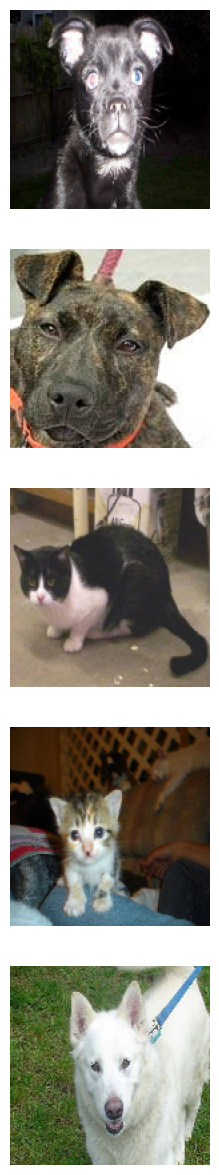

In [17]:
# 4
def plotImages(images_arr, probabilities = False):
    fig, axes = plt.subplots(len(images_arr), 1, figsize=(5,len(images_arr) * 3))
    if probabilities is False:
      for img, ax in zip( images_arr, axes):
          ax.imshow(img)
          ax.axis('off')
    else:
      for img, probability, ax in zip( images_arr, probabilities, axes):
          ax.imshow(img)
          ax.axis('off')
          if probability > 0.5:
              ax.set_title("%.2f" % (probability*100) + "% dog")
          else:
              ax.set_title("%.2f" % ((1-probability)*100) + "% cat")
    plt.show()


val_images, val_labels = next(val_data_gen)
plotImages(val_images[:5])


In [21]:
# 5
train_image_generator = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1)


Found 2000 images belonging to 2 classes.


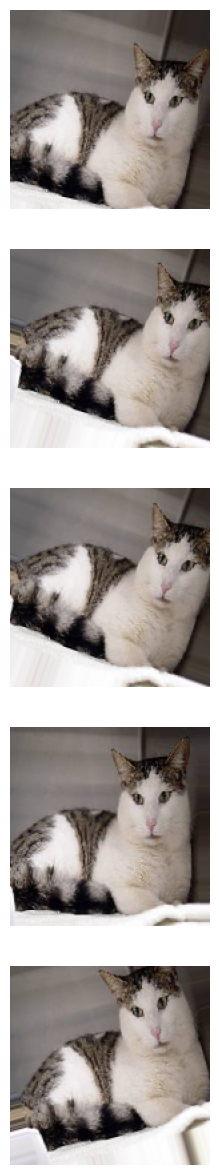

In [22]:
# 6
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary')

augmented_images = [train_data_gen[0][0][0] for i in range(5)]

plotImages(augmented_images)

In [26]:
# 7
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # binary output
])


model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    18,940,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,034,177 (72.61 MB)

 Trainable params: 19,034,177 (72.61 MB)

 Non-trainable params: 0 (0.00 B)

In [27]:
# 8
history = model.fit(
    train_data_gen,
    validation_data=val_data_gen,
    epochs=epochs
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.4702 - loss: 0.9758 - val_accuracy: 0.5040 - val_loss: 0.6874
Epoch 2/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 15s 927ms/step - accuracy: 0.5419 - loss: 0.6872 - val_accuracy: 0.6130 - val_loss: 0.6568
Epoch 3/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.6007 - loss: 0.6657 - val_accuracy: 0.6280 - val_loss: 0.6350
Epoch 4/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 15s 919ms/step - accuracy: 0.5903 - loss: 0.6591 - val_accuracy: 0.6350 - val_loss: 0.6284
Epoch 5/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 15s 917ms/step - accuracy: 0.6587 - loss: 0.6300 - val_accuracy: 0.6810 - val_loss: 0.5930
Epoch 6/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 893ms/step - accuracy: 0.6673 - loss: 0.6123 - val_accuracy: 0.6960 - val_loss: 0.5984
Epoch 7/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 15s 916ms/step - accuracy: 0.7048 - loss: 0.5836 - val_accuracy: 0.6820 - val_loss: 0.5875
Epoch 8/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.7313 - loss: 0.5409 - val_accuracy: 0.6

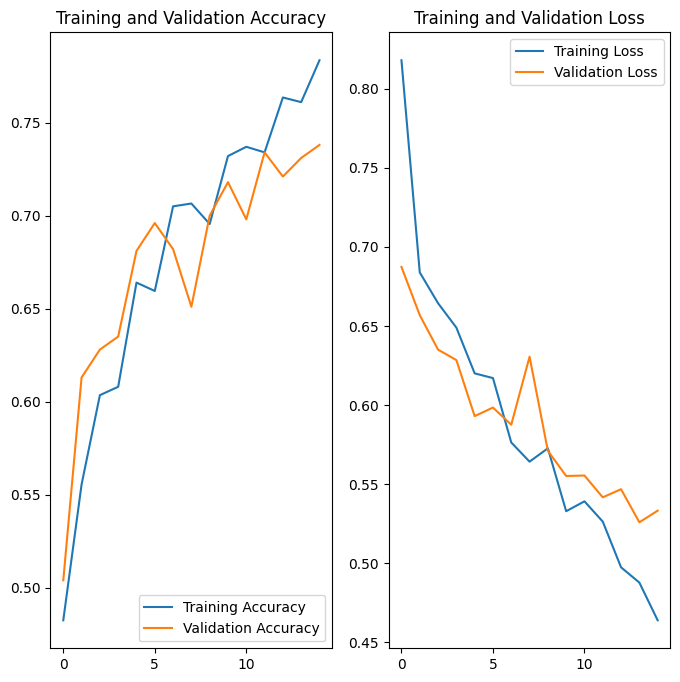

In [29]:
# 9
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [30]:
# 11
answers =  [1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
            1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0,
            1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
            1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1,
            0, 0, 0, 0, 0, 0]

correct = 0

for probability, answer in zip(probabilities, answers):
  if round(probability) == answer:
    correct +=1

percentage_identified = (correct / len(answers)) * 100

passed_challenge = percentage_identified >= 63

print(f"Your model correctly identified {round(percentage_identified, 2)}% of the images of cats and dogs.")

if passed_challenge:
  print("You passed the challenge!")
else:
  print("You haven't passed yet. Your model should identify at least 63% of the images. Keep trying. You will get it!")

NameError: name 'probabilities' is not defined